In [ ]:
import pandas as pd
import torch

In [221]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

tensor([1.], device='mps:0')


device(type='mps')

In [231]:
products_df = pd.read_json('../../data/products.json')
category_small_codes = [category_small_code[0] for category_small_code in products_df['category_small_code'].tolist()]
category_small_names = [category_small_name[0] for category_small_name in products_df['category_small_name'].tolist()]

products_df['category_code'] = category_small_codes
products_df['category_name'] = category_small_names

temp_df = products_df.sample(frac=1)[:10]
target_category_codes = temp_df['category_code'].tolist()

In [ ]:
train_image_urls = []
category_names = []
category_codes = []

for category_code in target_category_codes:
    tmp_df = products_df.sample(frac=1)[products_df['category_code'] == category_code][:10]

    train_image_urls.append(tmp_df['detail_image_url_1'].tolist())
    category_names.append(tmp_df['category_name'].tolist())
    category_codes.append(tmp_df['category_code'].tolist())

train_image_urls = [url for urls in train_image_urls for url in urls]
category_names = [c for category_name in category_names for c in category_name]
category_codes = [c for category_code in category_codes for c in category_code]

In [ ]:
# print(category_codes)
sample_category_codes=list(sorted(set(category_codes), key=category_codes.index))
sample_category_codes

sample_products_df = products_df[products_df['category_code'].isin(sample_category_codes)]
sample_target_category_codes = sample_products_df['category_code'].tolist()

In [ ]:
category_small_codes = [category_small_code[0] for category_small_code in temp_df['category_small_code'].tolist()]

In [ ]:
category_small_names = [category_small_name for category_small_name in temp_df['category_small_name'].tolist()]

In [ ]:
labels_keys = list(dict.fromkeys(category_small_codes))
label_dict = {code: {'label': labels_keys.index(code), 'category_name': name} for code, name in zip(category_small_codes, category_small_names)}

In [ ]:
train_labels = [label_dict[category_small_code]['label'] for category_small_code in category_codes]

In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import ViTImageProcessor, ViTForImageClassification
from torchvision import transforms
from PIL import Image
from io import BytesIO
import requests

class CustomImageDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_url = self.data[idx]
        label = self.labels[idx]

        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"image": image, "label": label}

In [ ]:
model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(label_dict.keys()))

train_data = train_image_urls

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomImageDataset(data=train_data, labels=train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 100

model.to(device)

for epoch in range(num_epochs):
    model.train()

    for batch in train_dataloader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(pixel_values=images, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

def predict(urls):
    row = int(len(urls) / 5) + 1
    col = int(len(urls) / 20)

    if row <= 2:
        col = len(urls)

    fig = plt.figure(figsize=(10, 7))

    for idx, url in enumerate(urls):
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            logits = model(**inputs).logits

        predicted_label = logits.argmax(-1).item()

        for key in label_dict.keys():
            if label_dict[key].get('label') == predicted_label:
                fig.add_subplot(row, col, idx+1)
                plt.imshow(image.resize((224, 224)).convert("RGB"))
                plt.axis('off')
                plt.title(f"{label_dict[key].get('category_name')[0]}")

In [ ]:
test_urls = [
    [],
    [],
    [], # 양말
    [],
]

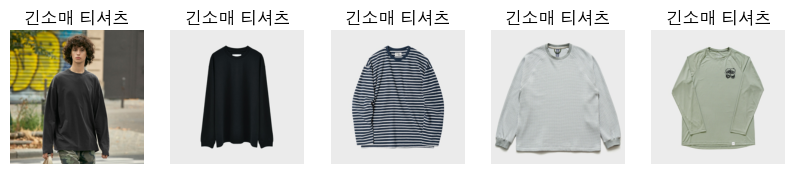

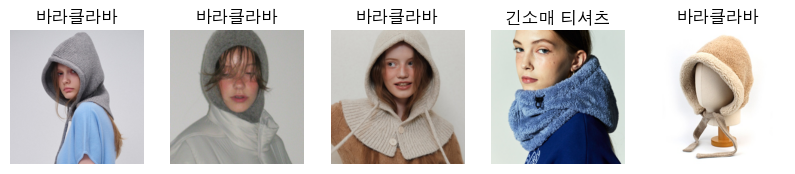

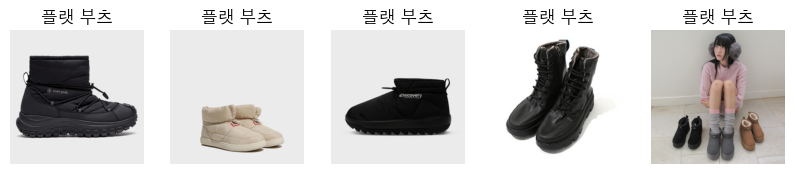

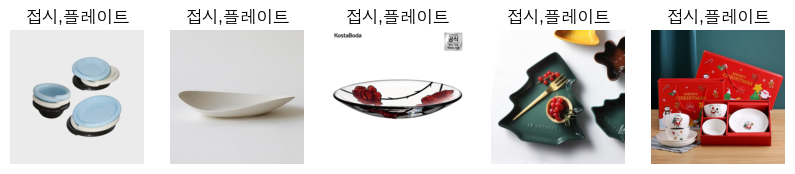

In [235]:
for test_url in test_urls:
    predict(test_url)